In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
from tqdm import trange
from scipy.stats import binned_statistic
from cn_tools.data_processing import merge_measurements, prepare_df
import os

In [3]:
path = '../Data/final/'
measurements = ['VF_005_analysis', 'VF_006_analysis', 'VF_007_analysis', 'VF_008_analysis']

def cut_lpf(df, low = 0.38, up = 0.74):
    mask1 = df.lpf > low
    mask2 = df.lpf < up

    mask = np.all([mask1, mask2], axis = 0)
    return df[mask]

z_phi_binned= {}
density = {}
for meas_key in measurements[:]:
    df = merge_measurements(path + meas_key +'/')
    df = prepare_df(df, scale_and_split=False)
    #df['lpf'] = (4/3*np.pi*(df.diameter/2)**3)/df.w000
    #df = cut_lpf(df)
    bin_means, bin_edges, binnumber = binned_statistic(df.lpf, df.contact_number, bins = 30)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    z_phi_binned[meas_key] = bin_centers, bin_means
    
    density[meas_key] = np.histogram(df.contact_number, bins = range(1,12), density = True)

100%|██████████████████████████████████████████████████████████████████| 308/308 [00:25<00:00, 12.05it/s]


Text(0, 0.5, '$Z_l$ binned average')

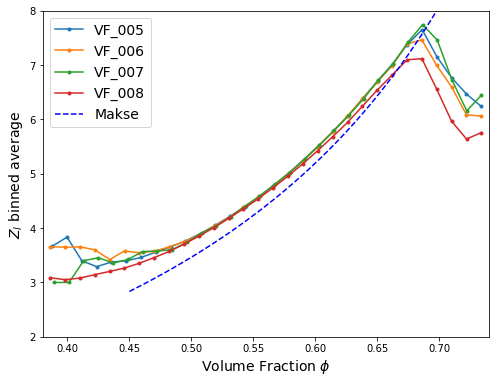

In [6]:
measurements = ['VF_005_analysis', 'VF_006_analysis', 'VF_007_analysis', 'VF_008_analysis']

plt.figure(figsize=(8,6))
for meas_key in measurements:
    bin_centers, bin_means = z_phi_binned[meas_key]
    plt.plot(bin_centers, bin_means, label = meas_key[:6], marker = '.')
    
def makse(x):
    return 2*np.sqrt(3)*x/(1-x)

x = np.linspace(0.45, 0.7, 50)
plt.xlim([0.38,0.74])
plt.ylim([2,8])
plt.plot(x, makse(x), 'b--', label = 'Makse')
plt.legend(fontsize = 14)
plt.xlabel('Volume Fraction $\phi$', fontsize = 14)
plt.ylabel('$Z_l$ binned average', fontsize = 14)
#plt.savefig('binned_z.pdf')

5.33


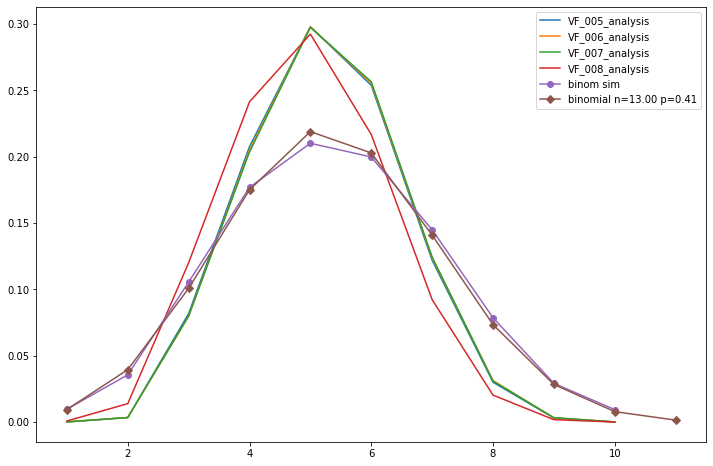

In [8]:
#df_red = df.sample(frac = 0.1)
plt.figure(figsize = (12,8))
#plt.scatter(df_red.lpf, df_red.contact_number, c = df_red.nn, marker = '.', cmap = 'rainbow', alpha = 1)
#plt.colorbar()
z_values = range(1,12)

for meas in measurements[:]:
    
    vals, bin_edges = density[meas]
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    plt.plot(z_values[:-1], vals, label = meas)
    
n = 13# df.nn.mean()
p = 0.41#df.contact_number.mean()/n
print(n*p)
data = np.random.binomial(n=n, p=p, size=10000)
data, bin_edges = np.histogram(data, bins = z_values, density = True)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

plt.plot(z_values[:-1], data, 'o-', label = 'binom sim')

# list of pmf values
bin_dist = [binom.pmf(r, n, p) for r in z_values ]

cn_dist = [(df.contact_number == z).sum()/df.shape[0] for z in z_values]

plt.plot(z_values, bin_dist, 'D-', label = f'binomial n={n:.2f} p={p:.2f}')
#plt.plot(z_values, cn_dist, 'D-', label = 'averages')
plt.legend()
#plt.xticks(np.arange(0,12))
plt.show()

In [138]:
r_values, len(bin_centers)

([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 11)

In [108]:
#ind = df.index.str.finadall('008_006')
#df.at[in]
#df[[i for i in df.index if '008_006' in i]]
#df.loc([i for i in df.index if '008_006' in i])
#df.loc[df.index]
#df.index
#df.loc[[i for i in df.index if '008_006' in i]]
#measurements[2:]
df.contact_number.mean()
(df.contact_number == 4)#.sum()
sum(bin_dist)

0.997135819579988

In [129]:
#plt.scatter(df.x, df.w010_x/df.w000)
df_spec = df.loc[[i for i in df.index if '008_009' in i]]
plt.figure(figsize = (12,8))
#plt.scatter(df_spec.r, df_spec.z, c = df_spec.lpf, marker = '.', cmap = 'hot')
#plt.colorbar()
#plt.scatter(df_cut.cc_0_x, df_cut.cc_0_y)
#plt.scatter(df.w010_x/df.w000, df.w010_y/df.w000, marker = '.')
from scipy import fftpack, ndimage
#image = ndimage.imread('image2.jpg', flatten=True)     # flatten=True gives a greyscale image
image = df_spec[['r', 'z']].values
fft2 = fftpack.fft2(image)

plt.imshow(fft2)
plt.show()

In [185]:
from sklearn.preprocessing import StandardScaler
min_fun = df.columns[:4].tolist()
min_ev = df.columns[16:34].tolist()
imt = df.columns[38:52].tolist()
com = [i for i in df.columns if 'com' in i]
curv_cen = [i for i in df.columns if 'cc' in i]
custom = ['nn', 'lpf']
features = min_fun + min_ev + imt + com + curv_cen + custom

In [144]:
scaler = StandardScaler()
df_x = pd.DataFrame(scaler.fit_transform(df_cut[features]), columns = features)
df_y = df_cut.contact_number

In [149]:
from sklearn.linear_model import LogisticRegression
lre = LogisticRegression(solver = 'saga')
lre.fit(df_x, df_y)

In [150]:
lre.score(df_x[custom], df_y)

In [152]:
df_y.loc[df_y == 5].shape[0]/df_y.shape[0]

In [134]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1, max_iter=300, verbose=True, hidden_layer_sizes = (64,32,16)).fit(df_x, df_y)

Iteration 1, loss = 1.30622560
Iteration 2, loss = 1.23648200
Iteration 3, loss = 1.22034364
Iteration 4, loss = 1.20962472
Iteration 5, loss = 1.20238125
Iteration 6, loss = 1.19694626
Iteration 7, loss = 1.19209154
Iteration 8, loss = 1.18799973
Iteration 9, loss = 1.18474211
Iteration 10, loss = 1.18201930
Iteration 11, loss = 1.17919164
Iteration 12, loss = 1.17765889
Iteration 13, loss = 1.17565067
Iteration 14, loss = 1.17433350
Iteration 15, loss = 1.17330973
Iteration 16, loss = 1.17148212
Iteration 17, loss = 1.17083569
Iteration 18, loss = 1.16988758
Iteration 19, loss = 1.16928097
Iteration 20, loss = 1.16852483
Iteration 21, loss = 1.16759964
Iteration 22, loss = 1.16727884
Iteration 23, loss = 1.16663405
Iteration 24, loss = 1.16587736
Iteration 25, loss = 1.16570839
Iteration 26, loss = 1.16487148
Iteration 27, loss = 1.16448075
Iteration 28, loss = 1.16414238
Iteration 29, loss = 1.16372146
Iteration 30, loss = 1.16325317
Iteration 31, loss = 1.16268961
Iteration 32, los

/home/ansgar/Workspace/CN_Analysis/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [148]:
lre.fit(df_x[custom], df_y, solver = 'saga')

TypeError: fit() got an unexpected keyword argument 'solver'